In [10]:
import matplotlib.pyplot as plt
import glob,scipy
import numpy as np
import scipy.ndimage as snd
from scipy import optimize
import seaborn as sb
from astropy.io import fits

%pylab inline

Populating the interactive namespace from numpy and matplotlib


### First grab a list of all filenames 3 directories deep inside of the defined root directory

In [11]:
rootdir='.'
all_fits_filenames=np.array(glob.glob(rootdir+'/Data/2018-05-17/*/*.fit'))
folder_names=np.array([fooname.split('/')[-2] for fooname in all_fits_filenames])
print (all_fits_filenames[:5],"...",all_fits_filenames[-5:])
print (unique(folder_names))

(array(['./Data/2018-05-17/2ndCal/8s.00000093.Mouse click position.fit',
       './Data/2018-05-17/2ndCal/8s.00000094.Mouse click position.fit',
       './Data/2018-05-17/2ndCal/8s.00000095.HIP 61958.fit',
       './Data/2018-05-17/3rdCal/10sR.00000096.HIP 61958.fit',
       './Data/2018-05-17/3rdCal/10sR.00000097.HIP 61958.fit'], 
      dtype='|S61'), '...', array(['./Data/2018-05-17/M51/180sHa.00000089.M 51.fit',
       './Data/2018-05-17/M51/300sHa.00000090.M 51.fit',
       './Data/2018-05-17/M51/300sHa.00000091.M 51.fit',
       './Data/2018-05-17/M51/300sHa.00000092.M 51.fit',
       './Data/2018-05-17/M51/30s.00000079.M 51.fit'], 
      dtype='|S61'))
['2ndCal' '3rdCal' 'Bias' 'Dark' 'Feige66' 'Flat' 'Focusing' 'M51']


### Now, using the image headers read in from fits.getheader, sort the exposures into flats, biases, science frames, etc., as well as reading in the filter names and exposure times

In [12]:
all_exp_types = np.array([fits.getheader(fooname)["IMAGETYP"] for fooname in all_fits_filenames])
print ("Our exposure types",unique(all_exp_types))

bias_filenames = all_fits_filenames[np.where(all_exp_types=='Bias Frame')]
print ("Number of bias frames",len(bias_filenames))

dark_filenames = np.sort(all_fits_filenames[np.where(all_exp_types=='Dark Frame')])
dark_exptimes=np.array([fits.getheader(fooname)["EXPTIME"] for fooname in dark_filenames])
print ("Number of darks and exposure times",str(len(dark_filenames)),unique(dark_exptimes))

flat_filenames = all_fits_filenames[np.where(all_exp_types=='Flat Field')]
flat_filter_names=np.array([fits.getheader(fooname)["FILTER"] for fooname in flat_filenames])
flat_exptimes=np.array([fits.getheader(fooname)["EXPTIME"] for fooname in flat_filenames])
print ("Flat filters and exposure times",unique(flat_filter_names),unique(flat_exptimes))


object_folder_name='M51'
object_filenames= all_fits_filenames[np.where((folder_names==object_folder_name))]# | (folder_names=='objectB'))]

object_filter_names=np.array([fits.getheader(fooname)["FILTER"] for fooname in object_filenames])
object_exptimes=np.array([fits.getheader(fooname)["EXPTIME"] for fooname in object_filenames])
print ("Object filters exposed and exposure times",unique(object_filter_names),unique(object_exptimes))


('Our exposure types', array(['Bias Frame', 'Dark Frame', 'Flat Field', 'Light Frame'], 
      dtype='|S11'))
('Number of bias frames', 20)
('Number of darks and exposure times', '8', array([ 200.]))
('Flat filters and exposure times', array(['B', 'H-a', 'I', 'R', 'V'], 
      dtype='|S3'), array([   1.,    5.,   10.,   11.,   14.,   38.,   90.,  130.]))
('Object filters exposed and exposure times', array(['B', 'H-a', 'I', 'R', 'V'], 
      dtype='|S3'), array([  30.,  100.,  120.,  150.,  180.,  300.]))


### Let's make a median bias, flat, and dark frame. Use the definition below to stack them up and take the median value for each pixel in the stack

In [14]:
# warning, reading in hundreds of bias frames may slow/kill your computer, index the filename array
#  if you want to use less than all

def median_combine(filelist):
    allimgs=[]
    for filename in filelist: allimgs.append(fits.getdata(filename))
    allimgs=np.array(allimgs)
    medianimg=np.median(allimgs,axis=0)
    return medianimg


In [15]:
flat_filter_names,flat_exptimes

(array(['R', 'R', 'R', 'H-a', 'H-a', 'H-a', 'V', 'V', 'V', 'B', 'B', 'B',
        'V', 'V', 'V', 'I', 'I', 'I'], 
       dtype='|S3'),
 array([  11.,   11.,   11.,  130.,  130.,  130.,   14.,   14.,   14.,
          38.,   38.,   38.,    1.,    5.,   10.,   90.,   90.,   90.]))

In [16]:
rootdir

'.'

In [17]:
thefilt='V'
flat_time=10

median_flat=median_combine(flat_filenames[np.where((flat_filter_names==thefilt) & (flat_exptimes==flat_time))])
fits.writeto(rootdir+thefilt+'-median_flat.fits',median_flat,clobber=True)   #clobber will overwrite old images

In [18]:
median_bias=median_combine(bias_filenames[:50])   # note that I take only the first 50 biases, to save time
fits.writeto(rootdir+'median_bias.fits',median_bias,clobber=True)

dark_time=100
median_dark=median_combine(dark_filenames[:][where(dark_exptimes==dark_time)])
median_dark=(median_dark-median_bias)/dark_time*1.0
fits.writeto(rootdir+'median_dark.fits',median_dark,clobber=True)


/Applications/anaconda/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Applications/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Display the median flat, bias, and dark. Note the lack of hot pixels in the 2014 data (when the camera could be properly cooled)

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(median_flat,vmax=np.median(median_flat)+3*np.std(median_flat),cmap=plt.cm.coolwarm)
plt.title('Median flat - '+thefilt,fontsize=25)
plt.colorbar()
plt.figure(figsize=(10,10))
plt.imshow(median_bias,vmax=np.median(median_bias)+3*np.std(median_bias),cmap=plt.cm.RdBu_r)
plt.title('Median bias frame',fontsize=25)
plt.colorbar()

plt.figure(figsize=(10,10))
plt.imshow(median_dark,vmax=np.median(median_dark)+3*np.std(median_dark),cmap=plt.cm.spring),colorbar()
plt.title('Median dark frame',fontsize=25)

### Now let's reduce the science frames using standard intrument signature removal. Note we subtract the dark from the science, and divide by a normalized flat

In [19]:
def reduce_raw_science_frames(science_filelist,median_bias,median_flat,median_dark):
    allreducedimgs=[]
    normed_flat=(median_flat-median_bias)/np.median(median_flat-median_bias)
    for filename in science_filelist: 
        science_frame=fits.getdata(filename)
        reduced_frame=(science_frame-median_dark-median_bias)/normed_flat
        allreducedimgs.append(reduced_frame)
    allreducedimgs=np.array(allreducedimgs)
    return allreducedimgs

### Read in the raw science frames and reduce them using the above definition

In [20]:
object_filter_names,object_exptimes

(array(['B', 'B', 'R', 'R', 'I', 'I', 'I', 'V', 'V', 'H-a', 'H-a', 'H-a',
        'H-a', 'B'], 
       dtype='|S3'),
 array([ 100.,  100.,  120.,  120.,  150.,  150.,  150.,  150.,  150.,
         180.,  300.,  300.,  300.,   30.]))

In [21]:
thefilt='V'
object_time=60
science_filenames=np.sort(object_filenames[np.where((object_filter_names==thefilt) & (object_exptimes==object_time))])
science_filenames=science_filenames
print science_filenames
science_reduced = reduce_raw_science_frames(science_filenames,median_bias,median_flat,median_dark*object_time)
science_exptimes=np.array([fits.getheader(fooname)["EXPTIME"] for fooname in science_filenames])
print science_exptimes
for i in range(len(science_reduced)):
    fits.writeto(science_filenames[i].replace('.fit','-'+thefilt+'-reduced.fits'),science_reduced[i],
                   clobber=True,header=fits.getheader(science_filenames[i]))

[]
[]


### What do the pixel values of the reduced frames look like? Note there is a sky level, which provides a noisy minimum to all of the reduced pixel values. Find it by taking a histogram of the pixel values and taking the pixel value which is at the maximum of the histogram

[]


/Applications/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


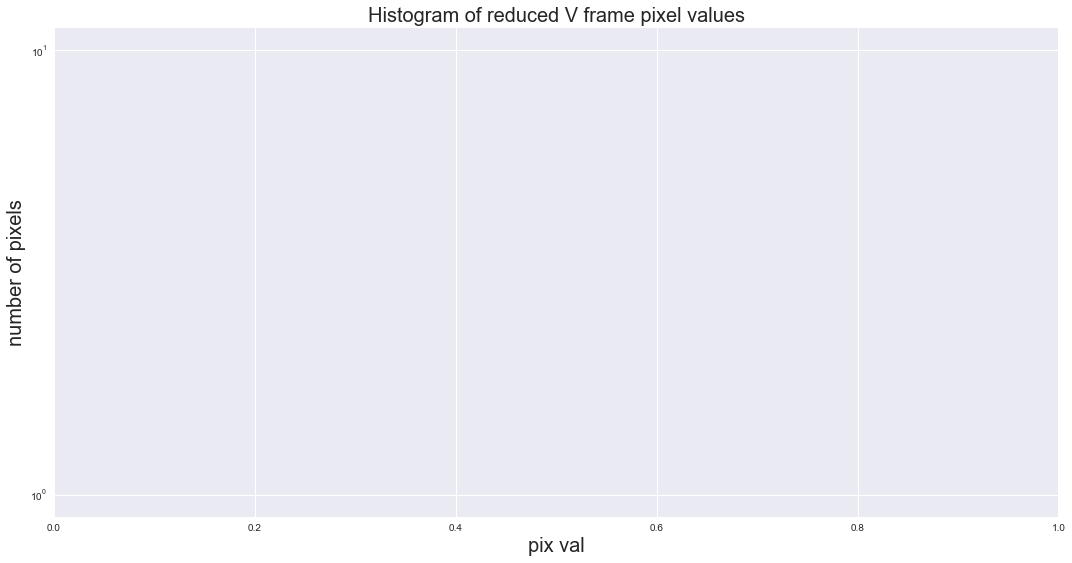

In [22]:
plt.figure(figsize=(18,9))
skylevels=[]
for i in range(len(science_reduced)):
    numpix,aduvals=np.histogram(science_reduced[i].flatten(),bins=1000,range=[-1e3,5e3])
    skylevel=aduvals[where(numpix==numpix.max())][0]
    skylevels.append(skylevel)
    plt.plot(aduvals[:-1],numpix,label=str(science_filenames[i].split('/')[-1]))
    plt.axvline(skylevel,color='k')
plt.xlabel('pix val',fontsize=20)
plt.ylabel('number of pixels',fontsize=20)
plt.yscale('log')
plt.legend()
print (skylevels)
plt.title('Histogram of reduced '+thefilt+' frame pixel values',fontsize=20)

### Show an example of the difference between reduced and unreduced

In [23]:
testnum=0  #the file number to show comparison plot
nstd=4
unreduced=fits.getdata(science_filenames[testnum])
figure(figsize=(20,8))
plt.subplot(121)
vmin_unred=np.median(median_bias)+skylevels[testnum]
plt.imshow(unreduced,cmap=cm.Greys,vmin=vmin_unred,vmax=vmin_unred+nstd*np.sqrt(skylevels[testnum]))
plt.colorbar()
plt.subplot(122)
plt.imshow(science_reduced[testnum],cmap=cm.Greys,vmin=skylevels[testnum],vmax=skylevels[testnum]+nstd*np.sqrt(skylevels[testnum]))
plt.colorbar()
plt.suptitle('The difference between reduced and unreduced',fontsize=25)

IndexError: index 0 is out of bounds for axis 0 with size 0

### Let's find some objects in the field, using a simplified object & centroid finder

In [24]:
def find_object_centroids_filterbysize(img,threshold,minsize):
    labels, num = snd.label(img > threshold, np.ones((3,3)))     # scipy labels/segments the image using a threshold
    centers = snd.center_of_mass(img, labels, range(1,num+1))    # scipy calculates the center of mass on the labeled img
    x = array(centers)[:,1]
    y = array(centers)[:,0]
    slices=snd.find_objects(labels)
    xs=np.array([objlabel[1].stop-objlabel[1].start for objlabel in slices])  # takes the min and max label slices
    ys=np.array([objlabel[0].stop-objlabel[0].start for objlabel in slices])  #  to find a rough object size

    maxsize=1025    # I hardcoded this in so that some spurious objects would be skipped. Change/delete if you like
    bigenough=np.where((xs>minsize) & (ys>minsize) & (xs<maxsize) & (ys<maxsize))
    xc,yc=x[bigenough],y[bigenough]
    xs,ys=xs[bigenough],ys[bigenough]
    
    print (str(len(xc))+' objects found')
    return xc,yc,xs,ys

### Test out the object finder on a single image

In [25]:
imgnum=0
nstd_aboveskynoise=12
threshold=skylevels[imgnum]+nstd_aboveskynoise*np.sqrt(skylevels[imgnum])   # decide on a threshold using the sky noise
minsize=2

xfoo,yfoo,xsfoo,ysfoo=find_object_centroids_filterbysize(science_reduced[imgnum],threshold,minsize)


plt.figure(figsize=(20,20))
plt.imshow(science_reduced[imgnum],cmap=cm.Greys,vmin=0,vmax=1.5*threshold)
plt.plot(xfoo,yfoo,'rs',mfc='None',markersize=20,markeredgecolor='b',markeredgewidth=2)
axis([0,1024,0,1024])

IndexError: list index out of range

### Just a little definition which can grab postage stamps of objects

In [ ]:
def get_stamp(img,starx,stary,ws):
    xlo,xhi,ylo,yhi=int(starx-ws),int(starx+ws),int(stary-ws),int(stary+ws)
    xmin,ymin=0,0
    xmax,ymax=np.shape(img)
    if xlo<xmin: xlo=xmin
    if xhi>xmax: xhi=xmax
    if ylo<ymin: ylo=ymin
    if yhi>ymax: yhi=ymax
    return img[ylo:yhi,xlo:xhi]

In [ ]:
len(xfoo)

In [ ]:
objnum=11
ws=30
stamp=get_stamp(science_reduced[imgnum],xfoo[objnum],yfoo[objnum],ws)
plt.imshow(stamp,interpolation='None',vmin=0,vmax=1.5*threshold)
xcfoo,ycfoo=ws+xfoo[objnum]-floor(xfoo[objnum]),ws+yfoo[objnum]-floor(yfoo[objnum])
plot(xcfoo,ycfoo,'wo')
plt.colorbar()
axis([0,ws*2,0,ws*2])
plt.title('a sample star')

In [ ]:
ns=1  # number of standard deviations from the mean to consider
m,s=mean(stamp[stamp<1500]),std(stamp[stamp<1500])
#gpix=np.where((stamp>m-ns*s) & (stamp<m+ns*s))[0]
#m,s=mean(stamp[gpix]),np.std(stamp[gpix])
axvline(m-s),axvline(m+s),axvline(m,color='r')
hist(stamp.flatten(),bins=100,range=[m-ns*s,m+ns*s],histtype='stepfilled',color='g',alpha=.3)
xlabel('ADU of background')
ylabel('Number of pixels')
print (m,s)

### Now find objects in all the reduced frames, again using the sky noise from each reduced image as a threshold. Plot all the centroids detected in each image to illustrate the dithering that occurs between frames

In [ ]:
nstd_aboveskynoise=10
thresholds=skylevels+nstd_aboveskynoise*np.sqrt(skylevels)

#thresholds=[threshold]*len(science_reduced)
minsize=2
catalog={'x':[],'y':[]}
xc_all,yc_all,xs_all,ys_all=[],[],[],[]
figure(figsize=(15,6))
for i in range(len(science_reduced)):
    xfoo,yfoo,xsfoo,ysfoo=find_object_centroids_filterbysize(science_reduced[i],thresholds[i],minsize)
    xc_all.append(xfoo)
    yc_all.append(yfoo)
    xs_all.append(xsfoo)
    ys_all.append(ysfoo)
    subplot(121)
    plot(xfoo,yfoo,'o')
    subplot(122)
    plot(xfoo,yfoo,'.')
    axis([0,400,600,1000])
subplot(121)
title('all objects found in all frames')
subplot(122)
title('zoomed in to illustrate dithering')

### Now let's make a little definition to find all matching objects given two frame's object centroids. If objects are chosen carefully, this can give us a rough offset between the frames, as is shown in the histogram below

In [ ]:
def find_closest(xc0,yc0,xc1,yc1,dr):
    nobjs1=len(xc1)
    x_off,y_off=[],[]
    for i in range(nobjs1):
        poss_match=np.where(np.sqrt((xc1[i]-xc0)**2+(yc1[i]-yc0)**2)<dr)[0]  # for each object in the second catalog, 
        x_off.extend([(xc1[i]-xc0[j]) for j in poss_match])                  #  find matches within a radius dr
        y_off.extend([(yc1[i]-yc0[j]) for j in poss_match])
    x_off=np.array(x_off)
    y_off=np.array(y_off)
    
    n_xoff,xfoo=np.histogram(x_off,bins=dr*2,range=[-dr,dr])   # histogram all the offsets to find the maximum value
    n_yoff,yfoo=np.histogram(y_off,bins=dr*2,range=[-dr,dr])   #  which corresponds to the rough offset between frames
    x_peak=(xfoo[where(n_xoff==np.max(n_xoff))])[0]+(xfoo[1]-xfoo[0])/2.
    y_peak=(yfoo[where(n_yoff==np.max(n_yoff))])[0]+(yfoo[1]-yfoo[0])/2.   # (note addition of half bin width)
    return x_off,y_off,x_peak,y_peak


In [ ]:
secondnum=0   #change this to be the second frame you want to see the offsets for
dr=60
xc0,yc0,xc1,yc1=xc_all[0],yc_all[0],xc_all[secondnum],yc_all[secondnum]
xoff,yoff,xpeak,ypeak=find_closest(xc0,yc0,xc1,yc1,dr)
 
    
hist(xoff,histtype='step',label='x offset',range=[-dr,dr],bins=dr,color='r')
hist(yoff,histtype='step',label='y offset',range=[-dr,dr],bins=dr,color='b')

axvline(xpeak,color='r')
axvline(ypeak,color='b')

xlabel('Nearest object centroid offset [pix]',fontsize=20)
ylabel('Number of objects',fontsize=20)
title('X/Y shift between frames',fontsize=25)

figure(figsize=(10,10))
plot(xc0,yc0,'g.')
plot(xc1-xpeak,yc1-ypeak,'o',mfc='None')

#axis([100,400,100,400])

### Going a little further than the simple offsets above, iterate on this process to find the overall shifts down to subpixel accuracy

In [ ]:
def find_frame_shifts(x0,y0,x1,y1,dr0,nsteps):    #like the def above, take in two sets of coordinates
    xshifts,yshifts=0,0
    drs=[dr0,20,10,5,2.5,1.25]
    for i in range(nsteps):
        dr=dr0/(1.+i)      # slowly reduce the matching radius, to get rid of outliers
        xoff,yoff,xpeak,ypeak=find_closest(x0,y0,x1-xshifts,y1-yshifts,dr)
        #print xoff,yoff
        n_xoff,xfoo=np.histogram(xoff,bins=50,range=[-dr,dr])
        n_yoff,yfoo=np.histogram(yoff,bins=50,range=[-dr,dr])
        #axvline(xpeak)
        print (xpeak)
        if i==0:
            xshift,yshift=xpeak,ypeak    # the first rough offset estimate is the peak of the offset histogram
        else:                            # successive offsets are found by taking the median value of the remainder
            xshift,yshift=np.median(xoff[np.abs(xoff)<dr/2.]),np.median(yoff[np.abs(yoff)<dr/2.])
        xshifts+=xshift        # add in each successive offset to the total
        yshifts+=yshift
        print (dr,xshifts,yshifts)
        #plot(xshifts,yshifts,'o')
    hist(xoff,histtype='step',color='r',bins=50)
    hist(yoff,histtype='step',color='b',bins=50)
    #plot(yfoo[1:],n_yoff,'b')
    axvline(xshift,color='r')
    axvline(yshift,color='b')
    return xshifts,yshifts

def find_closest(xc0,yc0,xc1,yc1,dr):
    nobjs1=len(xc1)
    x_off,y_off=[],[]
    for i in range(nobjs1):
        poss_match=np.where(np.sqrt((xc1[i]-xc0)**2+(yc1[i]-yc0)**2)<dr)[0]  # for each object in the second catalog, 
        x_off.extend([(xc1[i]-xc0[j]) for j in poss_match])                  #  find matches within a radius dr
        y_off.extend([(yc1[i]-yc0[j]) for j in poss_match])
    x_off=np.array(x_off)
    y_off=np.array(y_off)
    
    n_xoff,xfoo=np.histogram(x_off,bins=int(dr*2),range=[-dr,dr])   # histogram all the offsets to find the maximum value
    n_yoff,yfoo=np.histogram(y_off,bins=int(dr*2),range=[-dr,dr])   #  which corresponds to the rough offset between frames
    x_peak=(xfoo[where(n_xoff==np.max(n_xoff))])[0]+(xfoo[1]-xfoo[0])/2.
    y_peak=(yfoo[where(n_yoff==np.max(n_yoff))])[0]+(yfoo[1]-yfoo[0])/2.   # (note addition of half bin width)
    return x_off,y_off,x_peak,y_peak


### Perform this on the first and last images, to test the concept. The definition above also produces a histogram which can be used to ensure the algorithm is working properly

In [ ]:
firstnum,secondnum=0,0   #two different numbers corresponding to different frames
dr=60
xc0,yc0,xc1,yc1=xc_all[firstnum],yc_all[firstnum],xc_all[secondnum],yc_all[secondnum]
find_frame_shifts(xc0,yc0,xc1,yc1,dr,4)

### Now deploy the offset finder on all reduced images, relative to the first one

In [ ]:
xshifts,yshifts=np.zeros(len(science_reduced)),np.zeros(len(science_reduced))
for secondnum in range(1,len(science_reduced)):
    xshifts[secondnum],yshifts[secondnum]=find_frame_shifts(xc_all[0],yc_all[0],xc_all[secondnum],yc_all[secondnum],dr,4)

In [ ]:
xshifts,yshifts

### Use scipy's interpolation shifting algo to shift each reduced image by the negative of the offsets found above. This should match them all up

In [ ]:
shape(science_reduced)

In [ ]:
nzoom=4
resampled=np.zeros((len(science_reduced),1024*nzoom,1024*nzoom))
for k in range(len(science_reduced)):
    for i in range(1024):
        for j in range(1024):
            resampled[k,i*nzoom:(i+1)*nzoom,j*nzoom:(j+1)*nzoom]=science_reduced[k,i,j]
            

In [ ]:
science_shifted_resampled=np.array([snd.interpolation.shift(resampled[i],[-yshifts[i]*nzoom,-xshifts[i]*nzoom],order=3) for i in range(0,len(resampled))])


In [ ]:
fits.writeto(rootdir+thefilt+'-median-resampled.fits',np.median(science_shifted_resampled,axis=0),clobber='True')

In [ ]:
science_shifted_rescaled=np.array([snd.interpolation.shift(science_reduced[i],[-yshifts[i],-xshifts[i]],order=5)-skylevels[i] for i in range(0,len(science_reduced))])
stackedimg=np.median(science_shifted_rescaled,axis=0)

### Display the median of the stacked image to ensure it worked okay

In [ ]:
figure(figsize=(14,12))
title('Median stacked '+thefilt+' image',fontsize=10)
imshow(stackedimg,cmap=cm.Greys,vmin=0,vmax=20*np.sqrt(median(skylevels)))
colorbar()
#plt.axis([200,700,200,700])
fits.writeto(rootdir+thefilt+'-median.fits',stackedimg,clobber=True)

# Making an RGB image (aka align three images)

In [ ]:
rgbroot='/home/andrew/Pictures/20180504-Hutchison_Hamburglar/M66/'
rimg=fits.getdata(rgbroot+'00000086.NGC3627-R-reduced.fits')
gimg=fits.getdata(rgbroot+'00000088.NGC3627-V-reduced.fits')
bimg=fits.getdata(rgbroot+'00000087.NGC3627-B-reduced.fits')


In [ ]:
nstd_aboveskynoise=6
minsize=2
skylevel_r,skylevel_g,skylevel_b=np.median(rimg[rimg>0]),np.median(gimg[gimg>0]),np.median(bimg[bimg>0])

xr,yr,xsfoo,ysfoo=find_object_centroids_filterbysize(rimg,skylevel_r+nstd_aboveskynoise*np.sqrt(skylevel_r),minsize)
xg,yg,xsfoo,ysfoo=find_object_centroids_filterbysize(gimg,skylevel_g+nstd_aboveskynoise*np.sqrt(skylevel_g),minsize)
xb,yb,xsfoo,ysfoo=find_object_centroids_filterbysize(bimg,skylevel_b+nstd_aboveskynoise*np.sqrt(skylevel_b),minsize)


plot(xr,yr,'ro',alpha=.4)
plot(xg,yg,'go',alpha=.4)
plot(xb,yb,'bo',alpha=.4)
plt.figure()
plot(xr,yr,'ro',alpha=.4)
plot(xg,yg,'go',alpha=.4)
plot(xb,yb,'bo',alpha=.4)
plt.axis([100,400,600,900])

In [ ]:
dr=10
x_off_rb,y_off_rb=find_frame_shifts(xr,yr,xb,yb,dr,2)
x_off_rg,y_off_rg=find_frame_shifts(xr,yr,xg,yg,dr,2)

In [ ]:
figure(figsize=(10,10))
plot(xr,yr,'ro',alpha=.4)
plot(xg-x_off_rg,yg-y_off_rg,'go',alpha=.4)
plot(xb-x_off_rb,yb-y_off_rb,'bo',alpha=.4)
#axis([500,700,200,400])

In [ ]:
rgbroot

In [ ]:
g_shifted=snd.interpolation.shift(gimg,[-y_off_rg,-x_off_rg],order=1)
fits.writeto(rgbroot+'V-median-shifted.fits',g_shifted,clobber='True')

b_shifted=snd.interpolation.shift(bimg,[-y_off_rb,-x_off_rb],order=1)
fits.writeto(rgbroot+'B-median-shifted.fits',b_shifted,clobber='True')

In [ ]:
def scalesqrt(inputArray, scale_min=None, scale_max=None):
    """Performs sqrt scaling of the input numpy array."""

    imageData=numpy.array(inputArray, copy=True)

    imageData = imageData.clip(min=scale_min, max=scale_max)
    imageData = imageData - scale_min
    indices = numpy.where(imageData < 0)
    imageData[indices] = 0.0
    imageData = numpy.sqrt(imageData)
    imageData = imageData / math.sqrt(scale_max - scale_min)

    return imageData

### Read in three images for the r,g,b array. Each of these has been reduced, stacked, and shifted/rotated to be on a common coordinate system

In [ ]:
rgbroot

In [ ]:
rimg=fits.getdata(rgbroot+'00000086.NGC3627-R-reduced.fits')
gimg=fits.getdata(rgbroot+'V-median-shifted.fits')
bimg=fits.getdata(rgbroot+'B-median-shifted.fits')

rgbstack=[rimg,gimg,bimg]

### Do a rescaling of the image data for the purposes of making the RGB image (which needs values between 0 and 8 bits (0-255). I use the sqrt scaling used in the definition above, with a min and max defined by 0 and some number of std deviations above the sky noise

In [ ]:
nstd=11   # number of standard deviations above sky noise to call an RGB pixel=255
rgbimg=np.zeros((1024,1024,3))

for i in range(3):
    onecolor=rgbstack[i]
    colorstd,colormed=np.std(onecolor[onecolor>10]),np.median(onecolor[onecolor>10])
    scale_min,scale_max=colormed,nstd*colorstd
    rgbimg[:,:,i]=scalesqrt(onecolor, scale_min=scale_min, scale_max=scale_max)
    

### Finally, display our RGB image with imshow

In [ ]:
figure(figsize=(10,10))
imshow(rgbimg,interpolation='None')
#axis([150,800,50,800])
axis('off')

## Do a calibration  in the V band, using one exposure of the Landolt star (reduced)

In [ ]:
rgbroot

In [ ]:
#hflatmed=fits.getdata(rootdir+'H-a-median_flat.fits')
#median_bias=fits.getdata(rootdir+'median_bias.fits')

calibfilename=rgbroot+'00000088.NGC3627-V-reduced.fits'#[rootdir+'20160517/Calibration/Feige66.00000034.M_51.FIT']
vcalib=fits.getdata(calibfilename)#reduce_raw_science_frames(calibfilename,median_bias,hflatmed,median_bias)[0]



In [ ]:
imgnum=0
nstd_aboveskynoise=12
threshold=skylevels[imgnum]+nstd_aboveskynoise*np.sqrt(skylevels[imgnum])   # decide on a threshold using the sky noise
minsize=2

xfoo,yfoo,xsfoo,ysfoo=find_object_centroids_filterbysize(vcalib,threshold,minsize)


plt.figure(figsize=(20,20))
plt.imshow(vcalib,cmap=cm.Greys,vmin=0,vmax=1.5*threshold)
plt.plot(xfoo,yfoo,'rs',mfc='None',markersize=20,markeredgecolor='b',markeredgewidth=2)
for x,y,i in zip(xfoo,yfoo,range(len(xfoo))): plt.text(x+10,y+10,str(i),fontsize=20,color='b')
axis([0,1024,0,1024])

In [ ]:
figure(figsize=(20,8))
subplot(121)
foonum=8
yc,xc=int(xfoo[foonum]),int(yfoo[foonum])  #if using DS9 coordinates, be sure to to x->y and y->x  for translating to numpy array coords
wid=30
imshow(vcalib,vmin=700,vmax=1200,cmap=cm.gray_r,origin='lower')
cal_snip=vcalib[xc-wid:xc+wid,yc-wid:yc+wid]
subplot(122)
imshow(cal_snip,vmin=1000,vmax=2000,cmap=cm.gray,origin='lower'),colorbar()

### Plot a histogram of the background pixel values and take the median to find the sky level to subtract

In [ ]:
hist(cal_snip.flatten(),bins=100,range=[500,1500],histtype='stepfilled',color='g',alpha=.3)
xlabel('ADU of background')
ylabel('Number of pixels')
m,s=mean(cal_snip[cal_snip<1000]),std(cal_snip[cal_snip<1000])
axvline(m-s),axvline(m+s),axvline(m,color='r')
print m,s

### Calculate the centroid of the little standard star snippet

In [ ]:
xc,yc=0,0
pixsum=0
nx,ny=shape(cal_snip)
for i in range(nx):
    for j in range(ny):
        if cal_snip[j,i]>m+s:
            xc+=cal_snip[j,i]*i
            yc+=cal_snip[j,i]*j
            pixsum+=cal_snip[j,i]
xc,yc=xc/pixsum,yc/pixsum
print (xc,yc)

### Display the apertures centered around the standard star centroid

In [ ]:
dr=12
r=arange(0,30,dr)
phi=linspace(0,2*pi,1000)


figure(figsize=(8,6))
pcolor(cal_snip,vmin=500),colorbar()
plot(xc,yc,'wo')
for i in range(len(r)): plot(r[i]*cos(phi)+xc,r[i]*sin(phi)+yc,'r',alpha=.8)
#axis([25,80,30,80])

### Sum up the counts and number of pixels in the background and star annuli

In [ ]:
ann_flux=zeros(len(r))
ann_npix=zeros(len(r))
for i in range(nx):
    for j in range(ny):
        rdist=sqrt((xc-i)**2+(yc-j)**2)
        for k in range(len(r)):
            if ((rdist>r[k]) and (rdist<r[k]+dr)):
                ann_flux[k]+=cal_snip[j,i]
                ann_npix[k]+=1


print (r,ann_flux-ann_npix*m,(ann_flux-m*ann_npix)/ann_npix)

### Read in the exposure time and airmass for that calibration frame, and find the zeropoint offset

In [ ]:
calibfilename

In [ ]:
cal_exptime=float(fits.getheader(calibfilename)['EXPTIME'])
cal_airmass=float(fits.getheader(calibfilename)['AIRMASS'])
cal_vflux=ann_flux[0]-ann_npix[0]*m
print ("Exposure time is: "+ str(cal_exptime))
print ("Flux is: " +str(cal_vflux))

cal_vmag=-2.5*log10(cal_vflux/cal_exptime)
print ("Instrumental magnitude is, -2.5*log10(flux/time): " + str(cal_vmag))

cal_mag_ext=.15*cal_airmass
print ("The airmass is: " +str(cal_airmass)+", so given .15 magnitudes/airmass extinction, there are: " +str(cal_mag_ext))
print (" magnitudes of extincion.")

cal_vmag0=cal_vmag+cal_mag_ext
print ("So our final instrum. magnitude in V, removing atmospheric effects, is: " +str(cal_vmag0))


landolt_vmag=9.86
cal_vzpt=landolt_vmag-cal_vmag0
print ("Landolt says SA 103-302 is magnitude 9.86, so our zeropoint is then: " +str(cal_vzpt))

# Now perform aperture photometry on the object image, and convert to magnitudes per sq. arcsec using the calibration from above

### Make a series of radial apertures in which to measure flux, and overplot them on the image to analyze

In [ ]:
dr=10
objnum=4
wid=100
r=arange(0,wid,dr)
phi=linspace(0,2*pi,1000)
xc,yc=int(xfoo[objnum]),int(yfoo[objnum])  #int for using as numpy array coordinates
#wid=100

#v_med=vcalib#fits.getdata(rgbroot+'V-median-shifted.fits')
figure(figsize=(8,8))
#object_vsnip=vcalib[xc-wid:xc+wid,yc-wid:yc+wid]
imshow(vcalib,vmin=m,vmax=m+3*s,cmap=cm.Greys_r),colorbar()

#plot(xc,yc,'wo')
for i in range(len(r)): plot(r[i]*cos(phi)+xc,r[i]*sin(phi)+yc,'r',alpha=.8)
axis([xc-wid*2,xc+wid*2,yc-wid*2,yc+wid*2])

### What is the background level in the object image? Take the median in a limited range

In [ ]:
hist(vcalib.flatten(),range=[800,1000],bins=100)
xlabel('ADU value')
ylabel('Number of pixels')
title('Histogram of sky pixels in the field')
bkg=median(vcalib)
axvline(bkg,color='r')
print (bkg)


###  For each radial aperture, sum up the counts and number of pixels inside

In [ ]:
nx,ny=shape(vcalib)
ann_flux=zeros(len(r))
ann_npix=zeros(len(r))
# this loops over every pixel in the image (which is a rather brute force method)
for i in range(nx):
    for j in range(ny):
        rdist=sqrt((xc-i)**2+(yc-j)**2)
        for k in range(len(r)):
            if ((rdist>r[k]) and (rdist<r[k]+dr)):     # if the pixel is insize the kth aperture, add it to the tally
                ann_flux[k]+=vcalib[j,i]
                ann_npix[k]+=1


print (r,ann_flux-bkg*ann_npix,(ann_flux-bkg*ann_npix)/ann_npix)

### Now calculate the surface brightness, in calibrated units of magnitudes per square arcsecond. This requires knowledge of the fluxes in radial apertures (and the number of pixels in each aperture), the background, the exposure time, the pixel scale, and the airmass and calibration zeropoint

In [ ]:
objectairmass=float(fits.getheader(calibfilename)['AIRMASS'])
exptime=float(fits.getheader(calibfilename)['EXPTIME'])
pixscale=24*60/1024.
print ("The pixel scale is: "+str(pixscale)+ ", airmass is: " + str(objectairmass))

v_surfbright=-2.5*log10((ann_flux-bkg*ann_npix)/exptime)+2.5*log10(ann_npix*pixscale**2)+cal_vzpt+.15*objectairmass

In [ ]:
figure(figsize=(12,6))
plot(r*pixscale,v_surfbright,linewidth=4,alpha=.5)
axis([0,1.4*wid,24,17])
xlabel('Radius [arcsec]',fontsize=20)
ylabel('$\\mu$, surface brightness [mag/$arcsec^2$]',fontsize=20)
title('V band Radial surface brightness profile of object',fontsize=20)